# Sersic Fitting Measurement

In [1]:
#check what you actually use, delete unused imports
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
#from matplotlib.patches import Circle
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS
from astropy.modeling.functional_models import Sersic2D, Gaussian2D
from reproject import reproject_interp
from astropy.cosmology import FlatLambdaCDM
from pylab import contour, savefig
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.visualization import LogStretch, ManualInterval, ImageNormalize, PowerStretch
import math
import emcee
from scipy.optimize import minimize
import scipy.special as sp
from scipy import integrate
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from importlib import reload
import corner
import KnotFit as kf
from IPython.display import display, Math

In [2]:
reload(kf)

<module 'KnotFit' from '/home/brian/Documents/JHU/lensing/knotfit/KnotFit.py'>

In [46]:
indir = 'whl0137'
imfile = 'hlsp_relics_hst_wfc3ir-60mas_whl0137-08_f110w_drz.fits' 
imfile = os.path.join(indir,imfile)
#modeldir = 'whl0137/lens_modelling/testruns/z6twopt'
modeldir = 'whl0137/lens_modelling/GuillaumeMODELK/best'
dflx = os.path.join(modeldir, 'dx_z6.fits')
dfly = os.path.join(modeldir, 'dy_z6.fits')
#indir = 'macs0308'
#imfile = 'hlsp_relics_hst_wfc3ir-60mas_macs0308+26_total_drz.fits'
#imfile = os.path.join(indir, imfile)
#modeldir = 'macs0308/outputs/zitrin_ltm_gauss'
#dflx = os.path.join(modeldir, 'hlsp_relics_model_macs0308+26_zitrin-ltm-gauss_v1_x-arcsec-deflect.fits')
#dfly = os.path.join(modeldir, 'hlsp_relics_model_macs0308+26_zitrin-ltm-gauss_v1_y-arcsec-deflect.fits')

ax, ay, imdataHST = kf.initDeflection_Image(imfile, dflx, dfly, 
                                         zlens=0.356, zsource_in=6.0, zsource_out=6.2)
    
magnifinv = kf.makeMagnificationMap(ax, ay)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [51]:
imhdu = fits.open(imfile)
print(imhdu[0].header)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 5000                                                  NAXIS2  =                 5000                                                  EXTEND  =                    T                                                  COMMENT   FITS (Flexible Image Transport System) format is defined in 'AstronomyCOMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H FILENAME= '/grp/websites/relics.stsci.edu/private/macs0308+26/final_processing&'CONTINUE  '/images/hlsp_relics_hst_wfc3ir-60mas_macs0308+26_total_drz.fits&'    CONTINUE  '' / name o                                                           FILETYPE= 'SCI      '          / type of data found in data file                                                        

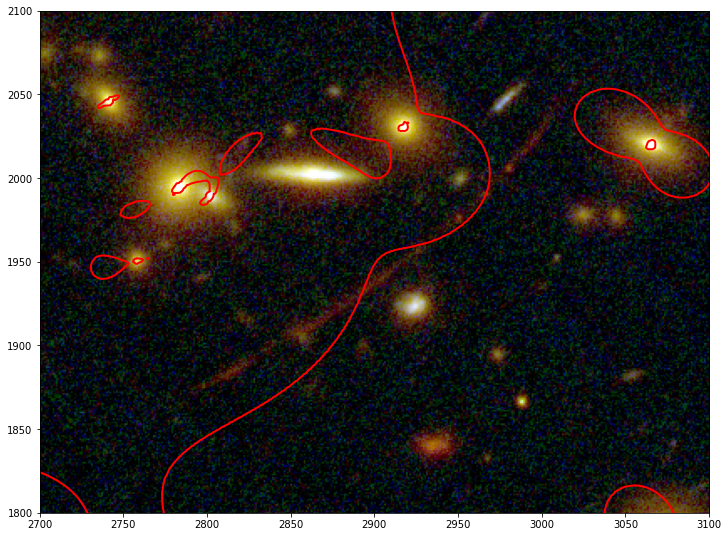

In [47]:
infile = 'whl0137-08_new_bright.png'
#infile = 'macs0308+26.png'
infile = os.path.join(indir, infile)
im = Image.open(infile)
im = im.transpose(Image.FLIP_TOP_BOTTOM)

# Define coordinate grid
yy, xx = np.indices(magnifinv.shape)

plt.figure(figsize=(12, 12.5))
plt.imshow(im, origin='lower')
xlo, xhi = 2700, 3100 #whl0137
ylo, yhi = 1800, 2100
#xlo, xhi = 3000, 3500 #macs0308
#ylo, yhi = 1500, 2000
plt.xlim(xlo, xhi)
plt.ylim(ylo, yhi)
con = plt.contour(xx, yy, magnifinv, [0], colors='r', linewidths=2)

In [48]:
# Source position grid
xss = xx - ax
yss = yy - ay

xlo, xhi = 2700, 3100 #whl0137
ylo, yhi = 1800, 2100
#xlo, xhi = 3000, 3500 #macs0308
#ylo, yhi = 1500, 2000

imstamp = imdataHST[ylo:yhi, xlo:xhi]

star = kf.starGen(imdataHST, starLoc=(2232, 1622))
#star = kf.starGen(imdataHST, starLoc=(2498, 3520))

rmsfile = 'hlsp_relics_hst_wfc3ir-60mas_whl0137-08_f110w_rms.fits'
#rmsfile = 'hlsp_relics_hst_wfc3ir-60mas_macs0308+26_total_rms.fits'
rmsfile = os.path.join(indir, rmsfile)

In [5]:
xmin, xmax = 2797, 3008
ymin, ymax = 1876, 2043

xmins = xmin - ax[ymin, xmin]
ymins = ymin - ay[ymin, xmin]
xmaxs = xmax - ax[ymax, xmax]
ymaxs = ymax - ay[ymax, xmax]

print(xmins, xmaxs, ymins, ymaxs)

2529.37898257784 2527.880230119729 2340.559523935774 2343.0139315176357


In [49]:
# add in simulated knot to check algorithm
#x_offset = 25
#x_sim, y_sim = 3258, 1779
#xs_sim = x_sim - ax[y_sim, x_sim]
#ys_sim = y_sim - ay[y_sim, x_sim]
#sersim1 = Sersic2D(amplitude=.1, r_eff=.5, n=4., x_0=xs_sim, y_0=ys_sim)
#sersim2 = Sersic2D(amplitude=0.1, r_eff=5, n=1., x_0=xs_sim-2, y_0=ys_sim-2)
#gauss = Gaussian2D(amplitude=3, x_mean=xs_sim, y_mean=ys_sim, x_stddev=.05, y_stddev=.05)
#xcut = xss[ylo:yhi, xlo:xhi]
#ycut = yss[ylo:yhi, xlo:xhi]
#sim_knot = sersim1(xcut, ycut) + sersim2(xcut, ycut)
#sim_knot = gauss(xcut, ycut)
#sim_convolved = convolve(sim_knot, star)

#imstamp[:,:] += sim_convolved[:,:]

# make argdict with simulated image added
#knotpos = (2950, 1976) # lower knot 
knotpos = (2980, 2006) # upper knot
#knotpos = (3298, 1779) # macs0308 bright
x, y = knotpos
xs = x - ax[y, x]
ys = y - ay[y, x]
#print(xs_sim, ys_sim)

argdict = kf.initArgDict(rmsfile, imstamp, limits=(xlo,xhi,ylo,yhi), ax=ax, ay=ay,
                      knotpos=knotpos, sourcegrid=(xss,yss), star=star, delta=5)


In [50]:
argdict = kf.initArgDict(rmsfile, imstamp, limits=(xlo,xhi,ylo,yhi), ax=ax, ay=ay,
                      knotpos=knotpos, sourcegrid=(xss,yss), star=star, delta=11)

print(xs-2, ys-2)

2523.42561912549 2338.843069749506


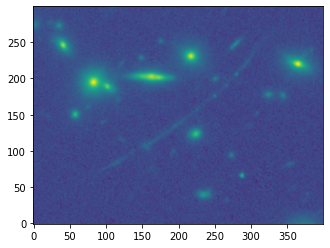

In [51]:
norm = ImageNormalize(stretch=LogStretch())

plt.imshow(imstamp, origin='lower', norm=norm)

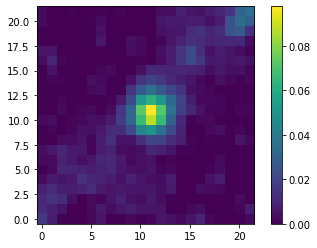

In [52]:
norm = ImageNormalize(stretch=LogStretch())
arcimage = argdict["arcIm"]
TB = argdict["knotbounds"]
tK = arcimage[TB[2]:TB[3], TB[0]:TB[1]]
plt.imshow((tK), origin='lower')
#plt.plot(9,9,'ro')
plt.colorbar()

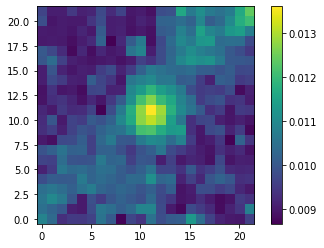

In [53]:
plt.imshow(argdict["sigma"], origin='lower')
plt.colorbar()

In [27]:
def neg_lhood(theta, argdict):
    return -kf.log_probability(theta, **argdict)

init = np.array([.1, .1, 1., .1, 1., 1., xs-1, ys-1])

sol = minimize(neg_lhood, init, args=argdict, method='Nelder-Mead', 
               options={'maxiter':2500})
#sol = minimize(l_opt, init, args=argdict)
print(sol)


 final_simplex: (array([[1.84681737e-04, 9.15706885e-02, 1.36710838e+00, 1.09455268e-01,
        1.11891050e+00, 1.63602008e+00, 2.67128835e+03, 2.24554326e+03],
       [1.84681748e-04, 9.15706885e-02, 1.36710838e+00, 1.09455268e-01,
        1.11891050e+00, 1.63602008e+00, 2.67128835e+03, 2.24554326e+03],
       [1.84681803e-04, 9.15706885e-02, 1.36710838e+00, 1.09455268e-01,
        1.11891050e+00, 1.63602008e+00, 2.67128835e+03, 2.24554326e+03],
       [1.84681911e-04, 9.15706885e-02, 1.36710838e+00, 1.09455268e-01,
        1.11891050e+00, 1.63602008e+00, 2.67128835e+03, 2.24554326e+03],
       [1.84681787e-04, 9.15706885e-02, 1.36710838e+00, 1.09455268e-01,
        1.11891050e+00, 1.63602008e+00, 2.67128835e+03, 2.24554326e+03],
       [1.84681779e-04, 9.15706885e-02, 1.36710838e+00, 1.09455268e-01,
        1.11891050e+00, 1.63602008e+00, 2.67128835e+03, 2.24554326e+03],
       [1.84681700e-04, 9.15706885e-02, 1.36710838e+00, 1.09455268e-01,
        1.11891050e+00, 1.63602008e+00, 2

In [101]:
theta = sol.x
#theta = np.array([0.001, 1., 1.]) #Gaussian
sampler = kf.runMCMC(theta, argdict, nwalkers=16, niter=5000, outfile='knotfit/chains/simknot/macs0308_bright_2sersic_pos.h5')

100%|██████████| 5000/5000 [2:44:15<00:00,  1.97s/it]   


In [54]:
mcmcfile = 'knotfit/chains/whl0137/topknot_sersic+gauss_pos.h5'
reader = emcee.backends.HDFBackend(mcmcfile)
samples = reader.get_chain(discard=100,flat=True)
lprob = reader.get_log_prob(discard=100,flat=True)

#samples = sampler.get_chain(discard=100, flat=True)
#lprob = sampler.get_log_prob(discard=100, flat=True)

amp = samples[:,0]
reff = samples[:,1]
#n = samples[:,2]

ix = tuple([lprob == max(lprob)])
rmax = reff[ix]
amax = amp[ix]
#nmax = n[ix]

sigr_plus = np.percentile(reff, 84)
sigr_minus = np.percentile(reff, 16)
sigr = (sigr_plus - sigr_minus) / 2.

siga_plus = np.percentile(amp, 84)
siga_minus = np.percentile(amp, 16)
siga = (siga_plus - siga_minus) / 2.

#sign_plus = np.percentile(n, 84)
#sign_minus = np.percentile(n, 16)
#sign = (sign_plus - sign_minus) / 2.


print('Radius: %.4f (%.4f) +- %.4f' %(rmax[0], np.median(reff), sigr))
print('Amplitude: %.4f (%.4f) +- %.4f' %(amax[0], np.median(amp), siga))
#print('Sersic index: %.2f (%.2f) +- %.2f' %(nmax[0], np.median(n), sign))

Radius: 0.0589 (0.0512) +- 0.0291
Amplitude: 1.2627 (1.2228) +- 0.0955


In [33]:
amp = samples[:,2]
reff = samples[:,3]
n = samples[:,4]

ix = tuple([lprob == max(lprob)])
rmax = reff[ix]
amax = amp[ix]
nmax = n[ix]

sigr_plus = np.percentile(reff, 84)
sigr_minus = np.percentile(reff, 16)
sigr = (sigr_plus - sigr_minus) / 2.

siga_plus = np.percentile(amp, 84)
siga_minus = np.percentile(amp, 16)
siga = (siga_plus - siga_minus) / 2.

sign_plus = np.percentile(n, 84)
sign_minus = np.percentile(n, 16)
sign = (sign_plus - sign_minus) / 2.


print('Radius: %.2f (%.2f) +- %.2f' %(rmax[0], np.median(reff), sigr))
print('Amplitude: %.4f (%.4f) +- %.4f' %(amax[0], np.median(amp), siga))
print('Sersic index: %.2f (%.2f) +- %.2f' %(nmax[0], np.median(n), sign))

Radius: 2.30 (1.58) +- 0.68
Amplitude: 0.0043 (0.0192) +- 0.0220
Sersic index: 5.36 (3.01) +- 3.02


In [14]:
xfit = samples[:,5]
yfit = samples[:,6]

ix = tuple([lprob == max(lprob)])
xfmax = xfit[ix]
yfmax = yfit[ix]

sigx_plus = np.percentile(xfit, 84)
sigx_minus = np.percentile(xfit, 16)
sigx = (sigx_plus - sigx_minus) / 2.

sigy_plus = np.percentile(yfit, 84)
sigy_minus = np.percentile(yfit, 16)
sigy = (sigy_plus - sigy_minus) / 2.


print('Radius: %.2f (%.2f) +- %.2f' %(xfmax[0], np.median(xfit), sigx))
print('Amplitude: %.2f (%.2f) +- %.2f' %(yfmax[0], np.median(yfit), sigy))

Radius: 2678.87 (2676.80) +- 4.00
Amplitude: 2217.17 (2213.39) +- 2.96


In [35]:
#################################
# Cosmology

h = 0.7  # Hubble constant / (100 km/s/Mpc)
Om = 0.3  # Omega matter
OL = 1 - Om  # Omega Lambda

H100 = 3.24077674937e-18  # 100 km/s/Mpc in units of 1 / S (inverse seconds)
c_mpc = 9.7155e-15  # MPC / S

def H(z):
    """Hubble constant [1/S] at redshift z for a flat universe"""
    return h * H100 * np.sqrt(Om * (1+z)**3 + OL)

def Hinv(z):
    return 1 / H(z)

def DA(z1, z2):
    """Angular-diameter distance (MPC)
    between two redshifts for a flat universe"""
    #return c / (1.+z2) * integral(lambda z: 1/H(z), z1, z2)
    return c_mpc / (1.+z2) * integrate.quad(Hinv, z1, z2)[0]

def DL(z1, z2):
    return c_mpc * (1+z2) * integrate.quad(Hinv, z1, z2)[0]

def gaussian(x, amp, sigma):
    mu = 0
    exp = -0.5 * ((x - mu) / sigma)**2
    return amp * np.exp(exp)

def gaussian2(x, y, amplitude, sigma):
    mu = 0
    exp = - 0.5 * (((x - mu) / sigma)**2 + ((y - mu) / sigma)**2)
    return amplitude * np.exp(exp)

In [44]:
def L_from_flux(flux, z, ABMAG_ZPT):
    mag = ABMAG_ZPT - 2.5 * np.log10(flux)
    Mag_sol = 4.52 #f110w, http://mips.as.arizona.edu/~cnaw/sun.html 
    #Mag_sol = 4.60 #f160w
    Lsol_erg = 3.826 * 10**33 #erg/s, https://www.cfa.harvard.edu/~dfabricant/huchra/ay145/units.html
    dist_pc = DL(0,z) * 10**6
    Mag = mag - 5*np.log10(dist_pc / 10.)
    #print(Mag)
    L_Lsol = 10**((Mag_sol - Mag) / 2.5)
    #print(L_Lsol)
    L_erg = L_Lsol * Lsol_erg
    return L_erg


### Assumes lam in Angstroms, L_uv in erg/s, SFR in Msun/yr
const = 3. * 10**(-47) #constant from Calzetti 2013

lam_obs = 11000 #angstrom
z = 6.2
lam_emit = lam_obs / (1+z)
PHOTFLAM = 1.5274129E-20 # Inverse sensitivity, ergs/cm2/A/e-, whl0137
PHOTPLAM = 1.1534459E+04 # Pivot wavelength (Angstroms), whl0137
#PHOTFLAM = 1.9275602E-20 #macs0308
#PHOTPLAM = 1.5369176E+04 #macs0308

ix = tuple([lprob == max(lprob)])
rs = samples[:,1]
amps = samples[:,0]
rmed = np.median(rs)
rmax = rs[ix]
rmax = rmax[0]
rplus = np.percentile(rs, 84)
rminus = np.percentile(rs, 16)
amed = np.median(amps)
amax = amps[ix]
amax = amax[0]
aplus = np.percentile(amps, 84)
aminus = np.percentile(amps, 16)

med_flux = integrate.dblquad(gaussian2, -np.inf, np.inf, lambda x: -np.inf, lambda x: np.inf, args=(amed, rmed))[0]
print(med_flux)
max_flux = integrate.dblquad(gaussian2, -np.inf, np.inf, lambda x: -np.inf, lambda x: np.inf, args=(amax, rmax))[0]
plus_flux = integrate.dblquad(gaussian2, -np.inf, np.inf, lambda x: -np.inf, lambda x: np.inf, args=(aplus, rplus))[0]
minus_flux = integrate.dblquad(gaussian2, -np.inf, np.inf, lambda x: -np.inf, lambda x: np.inf, args=(aminus, rminus))[0]
#sum_flux = integrate.quad(gaussian, -np.inf, np.inf, args=(a, r))[0]

ABMAG_ZPT = -2.5 * np.log10(PHOTFLAM) - 21.10 - 5 * np.log10(PHOTPLAM) + 18.692

Lmed = L_from_flux(med_flux, 6.2, ABMAG_ZPT)
Lmax = L_from_flux(max_flux, 6.2, ABMAG_ZPT)
Lplus = L_from_flux(plus_flux, 6.2, ABMAG_ZPT)
Lminus = L_from_flux(minus_flux, 6.2, ABMAG_ZPT)

SFRmed = const * lam_emit * Lmed
SFRmax = const * lam_emit * Lmax
SFRplus = const * lam_emit * Lplus
SFRminus = const * lam_emit * Lminus
SFRerror = (SFRplus + SFRminus) / 2.
print("SFR = %.3f (%.3f) +- %.3f" %(SFRmax, SFRmed, SFRerror))

0.02013340272358076
SFR = 0.209 (0.152) +- 0.194


In [35]:
### Assumes lam in Angstroms, L_uv in erg/s, SFR in Msun/yr
const = 3. * 10**(-47) #constant from Calzetti 2013

lam_obs = 11000 #angstrom
z = 6.2
lam_emit = lam_obs / (1+z)
mu = 20
PHOTFLAM = 1.5274129E-20 # Inverse sensitivity, ergs/cm2/A/e-

electrons = np.median(samples[:,0])
display(Math(r"A =  %.2f \ e^- s^{-1}" %(electrons)))
Flambda = electrons * PHOTFLAM # flux in erg/s/cm2/A
lambda_Flambda = lam_obs * Flambda # erg/s/cm2
display(Math(r"\lambda F_{\lambda} =  %.2e \ erg \ s^{-1} cm^{-2} A^{-1}" %(lambda_Flambda)))
dist = DL(0, z) * (3.086*10**24) #luminosity distance, converted from Mpc to cm
lambda_Llambda = lambda_Flambda * (4 * np.pi * dist**2)
display(Math(r"\lambda L_{\lambda} = %.2e \ erg \ s^{-1}"%(lambda_Llambda)))
sfr = const * lambda_Llambda
display(Math(r"SFR = %.2e \ M_{\odot} s^{-1}"%(sfr)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

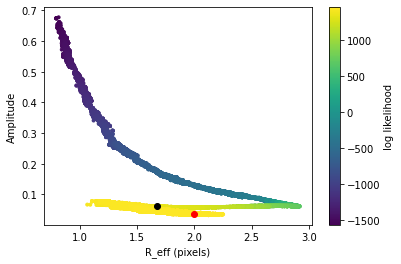

In [17]:
fig = plt.figure()

plt.scatter(reff, amp, c=lprob, marker='.')
plt.plot(rmax, amax, 'ro')
plt.plot(np.median(samples[:,1]), np.median(samples[:,0]), 'ko')
#plt.plot(8, 0.05, 'kx')
cb = plt.colorbar(label='log likelihood')
#plt.plot(450, 0.0007, 'ro')
#plt.loglog()
plt.xlabel('R_eff (pixels)')
plt.ylabel('Amplitude')

#plt.savefig('knotfit/chains/whl0137/lowknot_sersic+gauss_AvsR_log.png')
plt.show()

In [41]:
#reload(kf)
med_r = np.median(reff)
sigplus = np.percentile(reff, 84)
sigminus = np.percentile(reff, 16)
sig = (sigplus - sigminus) / 2.
print('reff = %.4f +- %.4f pixels' % (med_r, sig))
print('reff = %.2f +- %.2f pc' % (kf.pix_to_pc(med_r,6.3), kf.pix_to_pc(sig,6.3)))
#print('reff = %.4f +- %.4f pc' % (med_r, sig))
#print('reff = %.2f +- %.2f pixels' % (kf.pc_to_pix(med_r,6.2), kf.pc_to_pix(sig,6.2)))

reff = 0.3752 +- 0.0252 pixels
reff = 125.13 +- 8.42 pc


In [43]:
#reload(kf)
ix = [lprob == max(lprob)]
med_r = reff[ix]
med_r = med_r[0]
sigplus = np.percentile(reff, 84)
sigminus = np.percentile(reff, 16)
sig = (sigplus - sigminus) / 2.
print('reff = %.4f +- %.4f pixels' % (med_r, sig))
print('reff = %.2f +- %.2f pc' % (kf.pix_to_pc(med_r,6.3), kf.pix_to_pc(sig,6.3)))
#print('reff = %.4f +- %.4f pc' % (med_r, sig))
#print('reff = %.2f +- %.2f pixels' % (kf.pc_to_pix(med_r,6.2), kf.pc_to_pix(sig,6.2)))

reff = 0.3600 +- 0.0252 pixels
reff = 120.06 +- 8.42 pc


/home/brian/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until


[1.2227718250963215, 0.001, 0.01918400996849111, 1.5757089414490508, 3.0062233675800663, 2526.9786711381994, 2341.858221947324]


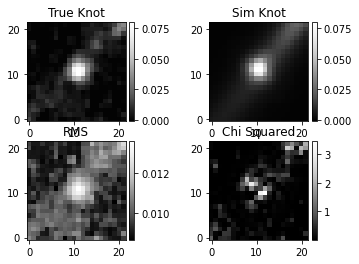

Total Chi-Squared: 100.13


In [60]:
#reload(kf)

theta = [np.median(samples[:,0]), 0.001, np.median(samples[:,2]),
         np.median(samples[:,3]), np.median(samples[:,4]), np.median(samples[:,5]), 
         np.median(samples[:,6])]#, np.median(samples[:,7])]
#theta = np.array([0.003, 1., 4., 0.01, 5., 1.])
#theta = np.array([amax[0], rmax[0]])
#theta = sol.x
print(theta)

cv = kf.convolved(theta,**argdict)
arcimage = argdict["arcIm"]

simimage = np.zeros_like(arcimage)
simimage[:,:] += cv[:,:]

TB = argdict["knotbounds"]
SB = argdict["knotbounds"]
tK = arcimage[TB[2]:TB[3], TB[0]:TB[1]]
sK = simimage[SB[2]:SB[3], SB[0]:SB[1]]

sigma = argdict['sigma']

Xsq = (tK - sK)**2 * (1/sigma**2) 

norm = ImageNormalize(stretch=LogStretch())

fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(2, 2)


im1 = ax1.imshow(tK, origin='lower', cmap='Greys_r', vmin=-0.001, vmax=0.08)

div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
ax1.set_title('True Knot')

im2 = ax2.imshow(sK, origin='lower', cmap='Greys_r', vmin=-0.001, vmax=0.08)

div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')
ax2.set_title('Sim Knot')

im3 = ax3.imshow(sigma, origin='lower', cmap='Greys_r')#, vmin=-0.001, vmax=0.08)

div3 = make_axes_locatable(ax3)
cax3 = div3.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax3, orientation='vertical')
ax3.set_title('RMS')

im4 = ax4.imshow(Xsq, origin='lower', cmap='Greys_r')#, vmin=0, vmax=50)

div4 = make_axes_locatable(ax4)
cax4 = div4.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax4, orientation='vertical')
ax4.set_title('Chi Squared')

#plt.savefig('whl0137/knots/modelC/nopt_compare.pdf')
plt.show()

print('Total Chi-Squared: %.2f' %np.sum(Xsq))

[1.2227718250963215, 0.051191274774043255, 0.01918400996849111, 1.5757089414490508, 3.0062233675800663, 2526.9786711381994, 2341.858221947324]


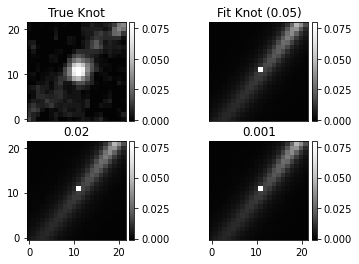

In [68]:
reload(kf)

theta = [np.median(samples[:,0]), np.median(samples[:,1]), np.median(samples[:,2]),
         np.median(samples[:,3]), np.median(samples[:,4]), np.median(samples[:,5]), 
         np.median(samples[:,6])]#, np.median(samples[:,7])]
#theta = np.array([0.003, 1., 4., 0.01, 5., 1.])
#theta = np.array([amax[0], rmax[0]])
#theta = sol.x
print(theta)

r2 = kf.pc_to_pix(100, 6.3)
theta2 = [np.median(samples[:,0]), 0.02, 
          np.median(samples[:,2]), np.median(samples[:,3]), np.median(samples[:,4]), 
          np.median(samples[:,5]), np.median(samples[:,6])]

r3 = kf.pc_to_pix(65, 6.3)
theta3 = [np.median(samples[:,0]), 0.000001, 
          np.median(samples[:,2]), np.median(samples[:,3]), np.median(samples[:,4]), 
          np.median(samples[:,5]), np.median(samples[:,6])]

cv = kf.convolved(theta,**argdict)
cv20 = kf.convolved(theta2, **argdict)
cv30 = kf.convolved(theta3, **argdict)
arcimage = argdict["arcIm"]

simimage = np.zeros_like(arcimage)
simim2 = np.copy(simimage)
simim3 = np.copy(simimage)

simimage[:,:] += cv[:,:]
simim2[:,:] += cv20[:,:]
simim3[:,:] += cv30[:,:]

TB = argdict["knotbounds"]
SB = argdict["knotbounds"]
tK = arcimage[TB[2]:TB[3], TB[0]:TB[1]]
sK = simimage[SB[2]:SB[3], SB[0]:SB[1]]
k20 = simim2[SB[2]:SB[3], SB[0]:SB[1]]
k30 = simim3[SB[2]:SB[3], SB[0]:SB[1]]

sigma = argdict['sigma']

Xsq = (tK - sK)**2 * (1/sigma**2) 

norm = ImageNormalize(stretch=LogStretch())

fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(2, 2)


im1 = ax1.imshow(tK, origin='lower', cmap='Greys_r', vmin=-0.001, vmax=0.08)

div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax1, orientation='vertical')
ax1.set_title('True Knot')
ax1.set_xticks([])

im2 = ax2.imshow(sK, origin='lower', cmap='Greys_r', vmin=-0.001, vmax=0.08)

div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax2, orientation='vertical')
ax2.set_title('Fit Knot (0.05)')
ax2.set_xticks([])
ax2.set_yticks([])

im3 = ax3.imshow(k20, origin='lower', cmap='Greys_r', vmin=-0.001, vmax=0.08)

div3 = make_axes_locatable(ax3)
cax3 = div3.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax3, orientation='vertical')
ax3.set_title('0.02')

im4 = ax4.imshow(k30, origin='lower', cmap='Greys_r', vmin=-0.001, vmax=0.08)

div4 = make_axes_locatable(ax4)
cax4 = div4.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax4, orientation='vertical')
ax4.set_title('0.001')
ax4.set_yticks([])

#plt.savefig('whl0137/knots/modelK/lowknot_radius_comp_variAmp_small.png')
plt.show()

In [ ]:
amp, r_eff, n = sol.x
#r_eff = 1.
#n = 4.
#amp = 5e-4
ellip = 0
a = r_eff
b = (1 - ellip) * r_eff
b_n = sp.gammaincinv(2*n,0.5)
Sersic_total = 2*np.pi*a*b*n*sp.gamma(2*n)*np.exp(b_n)/(b_n**(2*n))
flux = amp * Sersic_total
print(flux)

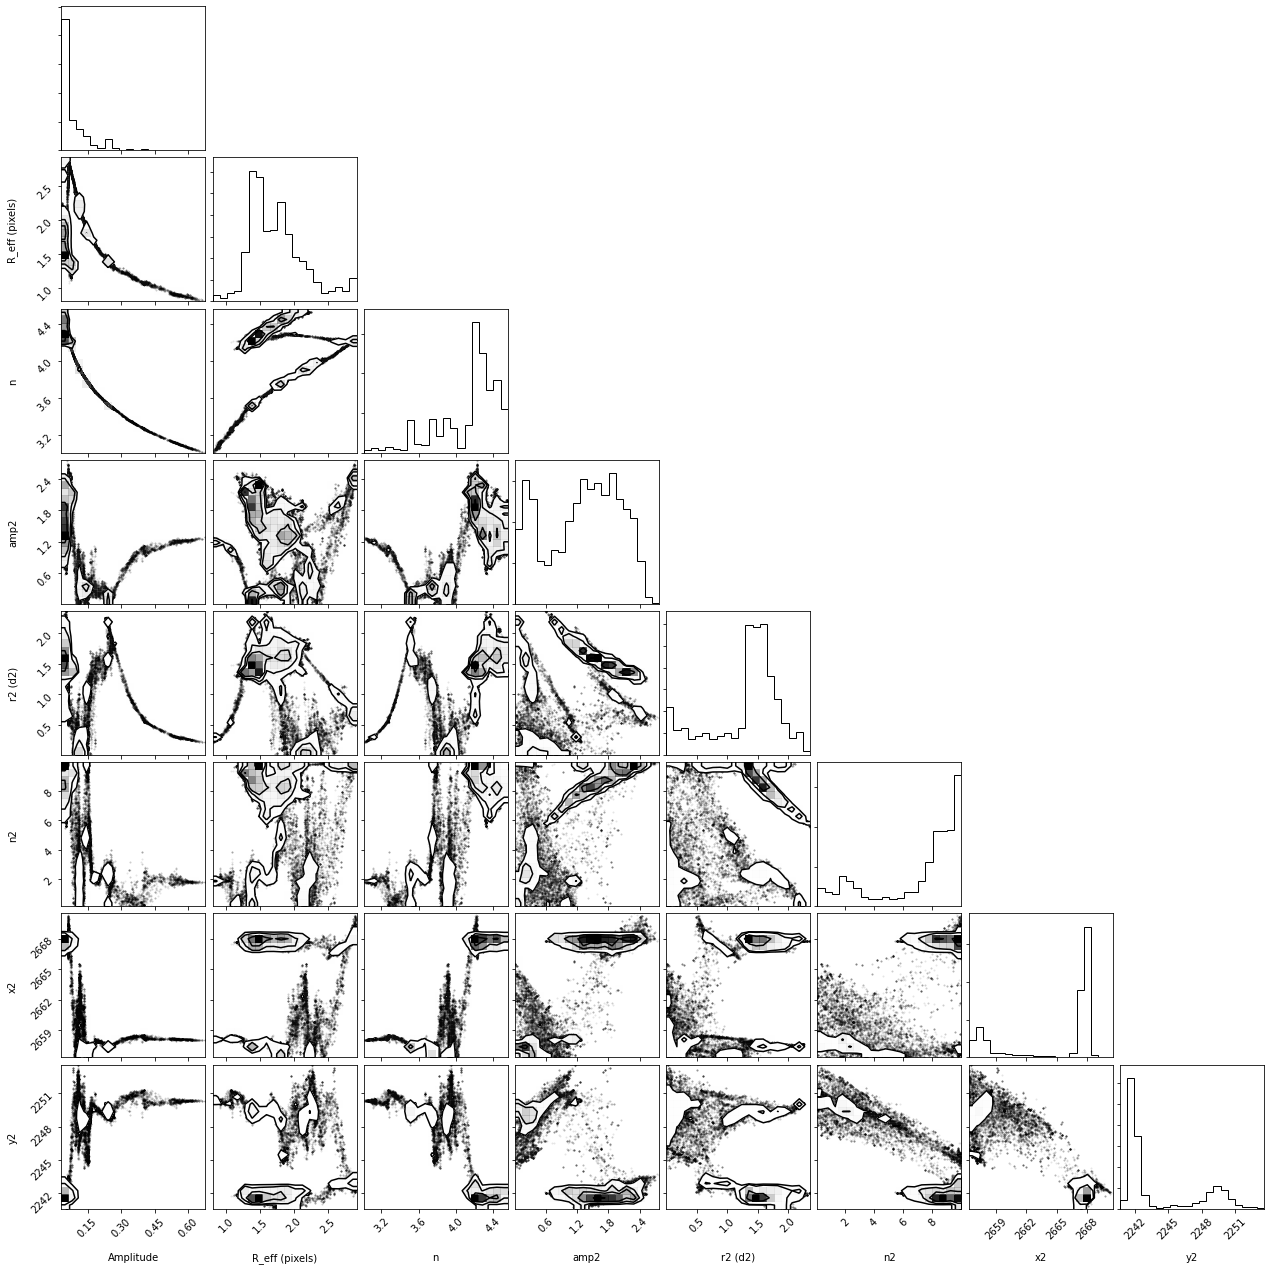

In [13]:
flat_samples = reader.get_chain(discard=100, flat=True)
#flat_samples = sampler.get_chain(discard=100, flat=True)

labels = ["Amplitude", "R_eff (pixels)", "n", "amp2", "r2 (d2)", 'n2', "x2", "y2"]
#truths = [0.005, .75, 4]

fig = corner.corner(flat_samples, labels=labels)#, truths=truths)
#plt.savefig('knotfit/simplots/twopiecesim_onepiecefit_corner.png')

In [ ]:
plt.hist(samples[:,2], bins=50)
plt.xlabel('Sersic index')
plt.show()

# Initial FWHM Calculation:

In [ ]:
import numpy as np
from scipy import integrate
from astropy.table import Table
from astropy import units as u
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [ ]:
def init(filename, bandpass):
    knot = Table.read(filename, format='ascii')
    mag = np.array(knot[bandpass])
    fwhm = np.array(knot['fwhm'])
    x = knot['x'][0]
    x = int(round(x))
    y = knot['y'][0]
    y = int(round(y))
    return mag, fwhm, x, y


def SFR(L_uv, lam):
    ### Assumes lam in Angstroms, L_uv in erg/s, SFR in Msun/yr
    const = 3. * 10**(-47) #constant from Calzetti 2013
    sfr = const * lam * L_uv 
    return sfr

def L_from_m(mag, z):
    #Mag_sol = 4.52 #f110w, http://mips.as.arizona.edu/~cnaw/sun.html 
    Mag_sol = 4.60 #f160w
    Lsol_erg = 3.826 * 10**33 #erg/s, https://www.cfa.harvard.edu/~dfabricant/huchra/ay145/units.html
    dist_pc = DL(0,z) * 10**6
    Mag = mag - 5*np.log10(dist_pc / 10.)
    #print(Mag)
    L_Lsol = 10**((Mag_sol - Mag) / 2.5)
    #print(L_Lsol)
    L_erg = L_Lsol * Lsol_erg
    return L_erg


def phys_radius_pc(fwhm, mu, z):
    kpc_arcmin = cosmo.kpc_proper_per_arcmin(z)
    kpc_arcsec = (kpc_arcmin*u.arcmin) / (60. * u.arcsec)
    print(kpc_arcsec)
    size_demag = fwhm / np.sqrt(mu)
    radius_kpc = (size_demag/2.) * kpc_arcsec.value
    return radius_kpc * 1000.


def main_measures(filename, bandpass, z, magnifGrid):
    mag, fwhm, x, y = init(filename, bandpass)
    
    mu = magnifGrid[y,x]
    mag_intrinsic = mag + 2.5 * np.log10(mu)
    lam_obs = int(bandpass[1:4]) * 100 #16000
    lam_emit = lam_obs / (1+z)
    
    LUV = L_from_m(mag_intrinsic,z)
    sfr = SFR(LUV,lam_emit)
    
    radius_pc = phys_radius_pc(fwhm, mu, z)
    print(mag, fwhm, sfr, radius_pc)
    return


#################################
# Cosmology

h = 0.7  # Hubble constant / (100 km/s/Mpc)
Om = 0.3  # Omega matter
OL = 1 - Om  # Omega Lambda

H100 = 3.24077674937e-18  # 100 km/s/Mpc in units of 1 / S (inverse seconds)
c_mpc = 9.7155e-15  # MPC / S

def H(z):
    """Hubble constant [1/S] at redshift z for a flat universe"""
    return h * H100 * np.sqrt(Om * (1+z)**3 + OL)

def Hinv(z):
    return 1 / H(z)

def DA(z1, z2):
    """Angular-diameter distance (MPC)
    between two redshifts for a flat universe"""
    #return c / (1.+z2) * integral(lambda z: 1/H(z), z1, z2)
    return c_mpc / (1.+z2) * integrate.quad(Hinv, z1, z2)[0]

def DL(z1, z2):
    return c_mpc * (1+z2) * integrate.quad(Hinv, z1, z2)[0]

In [ ]:
# z = 6
files = ['whl0137/z6_segfiles/1291.cat', 
        'whl0137/z6_segfiles/1349.cat']
#magnifications = [126, 409]
magnif = 1. / magnifinv

[main_measures(files[i], 'f110w_mag', z=6.2, magnifGrid=magnif) for i in range(len(files))]